In [36]:
import pandas as pd
import os
import tempfile
import src.utils as utils
from Bio.PDB import MMCIFParser, PDBIO, is_aa, PDBParser
import matplotlib.pyplot as plt
from src.tmalign import Tmalign
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

In [139]:
# Specify the path to the query chain structure and the target unit structure
query_name = "1qz7A"
target_name = "1qz7A_165_648"
query_structure_path = f"/home/soroushm/Documents/new_predictor_workframe/structure_files/chain/{query_name[1:3]}/{query_name}.pdb"
target_structure_path = f"/home/soroushm/Documents/new_predictor_workframe/structure_files/tmax/{target_name[1:3]}/{target_name}_tmax.pdb"

In [140]:
# Instantiate the essential modules
cif_parser = MMCIFParser(QUIET=True)
pdb_parser = PDBParser(QUIET=True)
io_handler = PDBIO()
tm_align = Tmalign(exe_path="/opt/tmalign/TMalign")
temp_dir = tempfile.mkdtemp()

In [141]:
# Parse the structure from the PDB file
qstructure = pdb_parser.get_structure(query_name, query_structure_path)
# Designate the chain from the structure
qchain = qstructure[0][query_name[4]]
# Extract residues from the chain
qchain_residues = [residue for residue in qchain.get_residues() if is_aa(residue.get_resname())]

# Do the same for the target structure
tstructure = pdb_parser.get_structure(target_name, target_structure_path)
tchain = tstructure[0][target_name[4]]
tchain_residues = [residue for residue in tchain.get_residues() if is_aa(residue.get_resname())]

In [142]:
# Specify the step of framing the fragments
# (frame_step = 1 --> moving the frame 1 residue per time --> highest resolution)
frame_step = 1
fragment_frame_list = utils.get_res_frames(res_range=qchain_residues, length=len(tchain), step=frame_step)

# Define the temporary dir to save the fragment structures
fragment_dir = tempfile.mkdtemp()

# Define a list to store the path to fragment structures
fragment_path_list = []
# Iterate the fragment frame list, extract and store each fragment structure
for fragment in fragment_frame_list:
    fragment_start = fragment[0].id[1]
    fragment_end = fragment[-1].id[1]
    fragment_out_path = os.path.join(fragment_dir, f"{query_name}_{fragment_start}_{fragment_end}.pdb")
    utils.get_structure(res_range=fragment, res_chain=query_name[4], structure=qstructure, out_path=fragment_out_path, io_handler=io_handler)
    fragment_path_list.append(fragment_out_path)

In [143]:
tmscore_results = []
for fragment_path in fragment_path_list:
    fragment_start = os.path.basename(fragment_path).split("_")[1]
    command_output = tm_align(target_structure_path, fragment_path)
    lines = command_output.split("\n")
    tm_score = None
    for line in lines:
        if line.startswith('TM-score=') and 'if normalized by average length' in line:
            # Extract the TM-score value
            tm_score = float(line.split('=')[1].split()[0])
            break  # Stop looping after finding the desired TM-score line

    tmscore_results.append([fragment_start, tm_score])

tm_score_results = [[int(i[0]), i[1]] for i in tmscore_results]
tm_score_results.sort(key=lambda x: x[0])

x = [i[0] for i in tm_score_results]
y = [i[1] for i in tm_score_results]

In [144]:
pd.DataFrame({"x": x, "y": y})

,x,y
0,142,0.48387
1,143,0.48793
2,144,0.48793
3,145,0.49694
4,146,0.50488
...,...,...
489,631,0.44704
490,632,0.40585
491,633,0.41084
492,634,0.41586


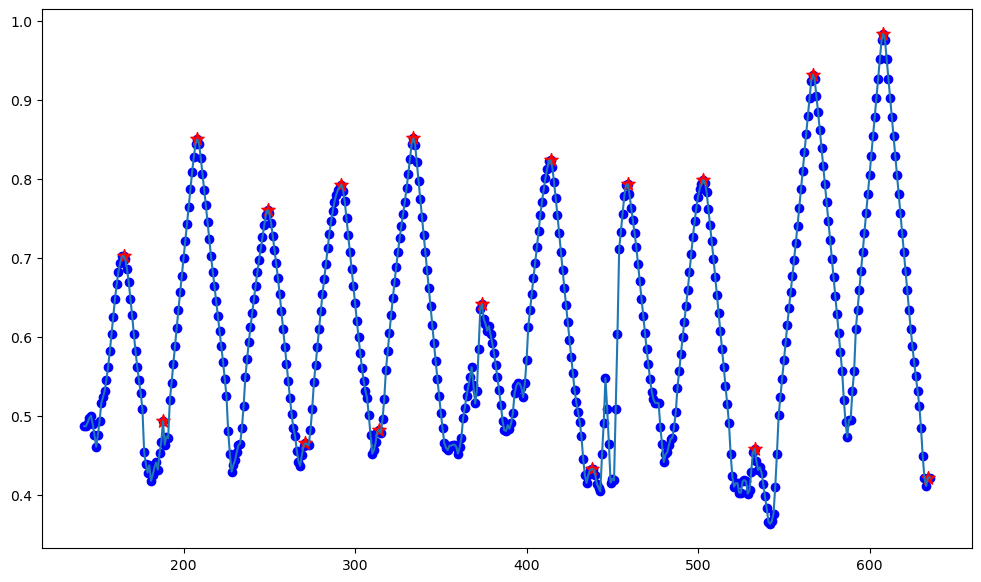

In [145]:
# Smooth the graph by 3 residue window size (smallest possible size --> reducing noise / not compromising resolution)
window_size = 3
if window_size % 2 == 0:
    window_size -= 1
poly_order = 0
y_smoothed_sg = savgol_filter(y, window_size, poly_order)

# Detect peaks and associated properties
peaks, properties = find_peaks(y_smoothed_sg, height=0, distance=round(len(tchain_residues) * 0.5),
                      threshold=0, prominence=0, width=0, plateau_size=0)

# Mark the peaks on y and x-axis
peaks_x = [x[peak_idx] for peak_idx in peaks]
peaks_y = [y_smoothed_sg[peak_idx] for peak_idx in peaks]

# Plot the results
plt.figure(figsize=(12, 7))
# Graph of all the residue vs tm-score points
plt.plot(x, y_smoothed_sg)
# Scatter of all the residue vs tm-score points
plt.scatter(x, y_smoothed_sg, marker='o', color='blue')
# Scatter of the detected peaks
plt.scatter(peaks_x, peaks_y, marker="*", color="red", s=100)
plt.show()

In [133]:
properties

{'plateau_sizes': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'left_edges': array([  2,  22,  65, 106, 147, 171, 191, 231, 271, 295, 316, 360, 389,
        424, 465, 492]),
 'right_edges': array([  2,  22,  65, 106, 147, 171, 191, 231, 271, 295, 316, 360, 389,
        424, 465, 492]),
 'peak_heights': array([0.50655   , 0.70901667, 0.85126333, 0.74398   , 0.78950667,
        0.47330333, 0.84305667, 0.60755   , 0.81139667, 0.42781667,
        0.77483333, 0.79094667, 0.47763333, 0.89716333, 0.96732667,
        0.44713   ]),
 'left_thresholds': array([0.00124   , 0.00186333, 0.00745333, 0.0069    , 0.00794   ,
        0.00568667, 0.00572333, 0.00568667, 0.00327667, 0.00218   ,
        0.00623333, 0.00732667, 0.02324333, 0.01079333, 0.00751   ,
        0.03018333]),
 'right_thresholds': array([2.36666667e-04, 3.81000000e-03, 3.67000000e-03, 1.46000000e-03,
        2.18333333e-03, 1.76000000e-03, 7.29333333e-03, 1.01766667e-02,
        5.17666667e-03, 3.11000000e-03, 5.4400000